In [1]:
from rasterio.windows import Window
import numpy as np
import json
import os
from pathlib import Path
import random
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import glob
import geopandas as gpd
import re
from shapely.geometry import box, mapping
from rasterio.transform import Affine
from rasterio import features
from shapely.affinity import affine_transform
from PIL import Image 

## import the function
from src.utils.util import load_config, load_json
from src.utils.utilstiles import map_path_to_tile_info, create_metadata_patches
from bitmap import generate_bitmaps_for_patches
from src.utils.plots import plot_images

In [ ]:
from src.utils import util
importlib.reload(util)

NameError: name 'reload' is not defined

## Config File

In [170]:
## load config
config = load_config(config_path="/mnt/d/desktop/drone-mapping/code/dev/src/config/config.yaml")

## Patching the whole COG using Cog2tiles function

For create the patch, the cog2tile is used. 

Warning: This function uses the grid provided by Mercantile, however do not have option for overlapping tiles. 

```
cog2tiles input.tif -z 19 --tile-size 512 --extension png --output-dir tiles/ --workers 64
```

In [7]:
os.getcwd()

'/mnt/d/desktop/drone-mapping/code/dev'

### Visualize generated patches

- All the paths are stored in the config path. see at: /config/config.yaml

In [3]:
## load config
config = load_config(config_path="/mnt/d/desktop/drone-mapping/code/dev/src/config/config.yaml")

## retrieve a list with all files 
list_files =  glob.glob(os.path.join(config["datasets"]["root_folder"], 
                                    config["datasets"]["name_tile_folder"], 
                                                                    '*.tif'
                                    )
                        )
                       

print('\n'.join(list_files[:2])) 


/mnt/d/desktop/drone-mapping/data/new_tiling/tiles/tile-199101-295965-19.tif
/mnt/d/desktop/drone-mapping/data/new_tiling/tiles/tile-199101-295966-19.tif


In [ ]:
# retrieve all patches created in a list 
# list_files =[]
# for dirpath, dirs, files in os.walk(os.path.join(config["datasets"]["root_folder"], config["datasets"]["name_tile_folder"])): 
#   for filename in files:
#     fname = os.path.join(dirpath,filename)
#     if fname.endswith('.tif'):
#       list_files.append(fname)

tile-199111-295967-19.tif


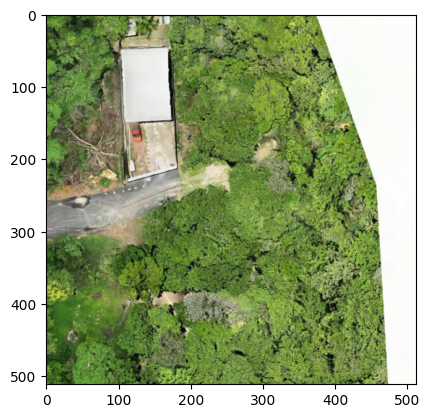

In [7]:
## show random image from list of paths
img_path = random.sample(list_files,1)[0]
img = cv2.imread(img_path)
print(img_path.split('/')[-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert BGR to RGB
plt.imshow(img)


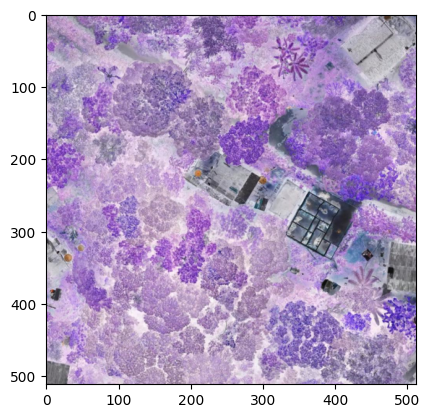

In [29]:
from skimage.util import invert
invert = invert(img)
plt.imshow(invert)

## Patching Building Footprint

Using mercantile and cog2tiles. 

Mercantile gives the same patches as the given by cog2tiles. 
The following function will add metadata into each patch created at.

In [8]:
## PATH of the metadata json containing the grids.
geojson_mercantile_path = config["datasets"]["grid_tiles_json"]

## read as geopandas
gdf = gpd.read_file(geojson_mercantile_path)

## add columns
gdf['x_tile'] = gdf['id'].apply(lambda obj : int(re.findall( "[0-9].*", obj.split(',')[0])[0]))
gdf['y_tile'] = gdf['id'].apply(lambda obj : int(re.findall( "[0-9].*", obj.split(',')[1])[0]))
gdf['z_tile'] = gdf['id'].apply(lambda obj : int(re.findall( "[0-9].", obj.split(',')[2])[0]))

In [35]:
gdf.head()

,id,title,geometry,x_tile,y_tile,z_tile
0,"(199101, 295964, 19)","XYZ tile (199101, 295964, 19)","POLYGON ((-43.28819 -22.61211, -43.28819 -22.6...",199101,295964,19
1,"(199102, 295964, 19)","XYZ tile (199102, 295964, 19)","POLYGON ((-43.28751 -22.61211, -43.28751 -22.6...",199102,295964,19
2,"(199103, 295964, 19)","XYZ tile (199103, 295964, 19)","POLYGON ((-43.28682 -22.61211, -43.28682 -22.6...",199103,295964,19
3,"(199104, 295964, 19)","XYZ tile (199104, 295964, 19)","POLYGON ((-43.28613 -22.61211, -43.28613 -22.6...",199104,295964,19
4,"(199105, 295964, 19)","XYZ tile (199105, 295964, 19)","POLYGON ((-43.28545 -22.61211, -43.28545 -22.6...",199105,295964,19


In [38]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Create metadata

It creates the metadata by looking at each image and adding relevant metadata from the grid metadata. So each image stores relevant information in a json file with the same name as the input image, however, stored in another folder.

In [9]:
output_dir = "/mnt/d/desktop/drone-mapping/data/new_tiling/tiles_metadata"

## See function for a better understandment 
create_metadata_patches(gdf, list_files,output_dir)

Reading tile: /mnt/d/desktop/drone-mapping/data/new_tiling/tiles/tile-199101-295965-19.tif
Metadata saved to tile-199101-295965-19.json
Reading tile: /mnt/d/desktop/drone-mapping/data/new_tiling/tiles/tile-199101-295966-19.tif
Metadata saved to tile-199101-295966-19.json
Reading tile: /mnt/d/desktop/drone-mapping/data/new_tiling/tiles/tile-199101-295967-19.tif
Metadata saved to tile-199101-295967-19.json
Reading tile: /mnt/d/desktop/drone-mapping/data/new_tiling/tiles/tile-199101-295968-19.tif
Metadata saved to tile-199101-295968-19.json
Reading tile: /mnt/d/desktop/drone-mapping/data/new_tiling/tiles/tile-199101-295969-19.tif
Metadata saved to tile-199101-295969-19.json
Reading tile: /mnt/d/desktop/drone-mapping/data/new_tiling/tiles/tile-199101-295970-19.tif
Metadata saved to tile-199101-295970-19.json
Reading tile: /mnt/d/desktop/drone-mapping/data/new_tiling/tiles/tile-199101-295971-19.tif
Metadata saved to tile-199101-295971-19.json
Reading tile: /mnt/d/desktop/drone-mapping/data/

In [12]:
## load a single metadata to see it
list_metadata = glob.glob(os.path.join(config["datasets"]["root_folder"], config["datasets"]["name_metadata_folder"],"*.json"))
    
load_json(list_metadata[1])

{'patch_id': '(199101, 295966, 19)',
 'x_tile': 199101,
 'y_tile': 295966,
 'z_tile': 19,
 'filename': 'tile-199101-295966-19',
 'crs': 'EPSG:4326',
 'geometry': 'POLYGON ((-43.28819274902344 -22.613377019307272, -43.28819274902344 -22.612743161323397, -43.287506103515625 -22.612743161323397, -43.287506103515625 -22.613377019307272, -43.28819274902344 -22.613377019307272))',
 'max_gray_value': 255,
 'min_gray_value': 0,
 'max_min_diff': 255,
 'percentage_white': 0.7334,
 'percentage_black': 0.2635,
 'sum_black_white': 0.9969000000000001}

## Bitmap - Building Footprint

In [ ]:
from src.utils import utilstiles
from src.utils.utilstiles import find_tile_per_x_y_z, add_folder_to_path_name

In [ ]:
from plots import print_img, plot_images, plot_pairwise_simple, plot_pairwise

In [21]:
## get footprint shapefile inside the folders
for dirpath, dirs, files in os.walk('/mnt/d/Desktop/drone-mapping/data'): 
  for filename in files:
    fname = os.path.join(dirpath,filename)
    if fname.endswith('.shp'):
      print(fname)

/mnt/d/Desktop/drone-mapping/data/shp/building-footprint.shp


In [22]:
## load buildings footprint shp
buildings = gpd.read_file(fname)
buildings["id"] = buildings.index

##CONVERT 4326
buildings4326 = buildings.to_crs("EPSG:4326")

In [26]:

def find_tile_per_x_y_z(x:int,y:int,z:int):
    path = "tile-"+str(x)+"-"+str(y)+"-"+str(z)+".tif"
    return path

def add_folder_to_path_name(filename,folder):
    return os.path.join(folder,filename)


## Folder path name 
folder_tile_path = os.path.join(config["datasets"]["root_folder"], config["datasets"]["name_tile_folder"])


## Create new columns 
gdf["path_name"]=gdf.apply(lambda row:find_tile_per_x_y_z(row["x_tile"],
                                                          row["y_tile"],
                                                          row["z_tile"]),axis=1)
gdf["full_path"] = gdf.apply(lambda row: add_folder_to_path_name(row["path_name"],
                                                                 folder_tile_path),
                                                                axis=1)

### Spatial Intersection of Grid tiles and each patche

In [30]:
from src.utils.bitmap import create_binary_mask, generate_bitmaps

In [27]:
## create the spatial join gdf that will hold the whole operation downstream
intersection = buildings4326.sjoin(gdf, how='left', predicate="intersects", lsuffix="buildings",rsuffix="tile")

intersection.head()

,id_buildings,geometry,index_tile,id_tile,title,x_tile,y_tile,z_tile,path_name,full_path
0,0,"POLYGON ((-43.28463 -22.6179, -43.28453 -22.61...",235,"(199106, 295974, 19)","XYZ tile (199106, 295974, 19)",199106,295974,19,tile-199106-295974-19.tif,/mnt/d/desktop/drone-mapping/data/new_tiling/t...
1,1,"POLYGON ((-43.28491 -22.61576, -43.28484 -22.6...",142,"(199105, 295970, 19)","XYZ tile (199105, 295970, 19)",199105,295970,19,tile-199105-295970-19.tif,/mnt/d/desktop/drone-mapping/data/new_tiling/t...
2,2,"POLYGON ((-43.28459 -22.61576, -43.28448 -22.6...",143,"(199106, 295970, 19)","XYZ tile (199106, 295970, 19)",199106,295970,19,tile-199106-295970-19.tif,/mnt/d/desktop/drone-mapping/data/new_tiling/t...
3,3,"POLYGON ((-43.28379 -22.61615, -43.2837 -22.61...",167,"(199107, 295971, 19)","XYZ tile (199107, 295971, 19)",199107,295971,19,tile-199107-295971-19.tif,/mnt/d/desktop/drone-mapping/data/new_tiling/t...
4,4,"POLYGON ((-43.28371 -22.61646, -43.28366 -22.6...",167,"(199107, 295971, 19)","XYZ tile (199107, 295971, 19)",199107,295971,19,tile-199107-295971-19.tif,/mnt/d/desktop/drone-mapping/data/new_tiling/t...


## BitMap

In [37]:
from src.utils.bitmap import generate_bitmaps

In [38]:
folder_bitmap_path = "/mnt/d/desktop/drone-mapping/data/new_tiling/bitmap"

## generate the bitmap
generate_bitmaps(intersection,
                             gdf,
                             folder_bitmap_path,
                             save_format="png")

Processing Intersection 27 (0/72)
  ✓ Saved: tile-199105-295965-19.png
Processing Intersection 30 (1/72)
  ✓ Saved: tile-199108-295965-19.png
Processing Intersection 31 (2/72)
  ✓ Saved: tile-199109-295965-19.png
Processing Intersection 49 (3/72)
  ✓ Saved: tile-199104-295966-19.png
Processing Intersection 50 (4/72)
  ✓ Saved: tile-199105-295966-19.png
Processing Intersection 53 (5/72)
  ✓ Saved: tile-199108-295966-19.png
Processing Intersection 72 (6/72)
  ✓ Saved: tile-199104-295967-19.png
Processing Intersection 73 (7/72)
  ✓ Saved: tile-199105-295967-19.png
Processing Intersection 74 (8/72)
  ✓ Saved: tile-199106-295967-19.png
Processing Intersection 75 (9/72)
  ✓ Saved: tile-199107-295967-19.png
Processing Intersection 96 (10/72)
  ✓ Saved: tile-199105-295968-19.png
Processing Intersection 97 (11/72)
  ✓ Saved: tile-199106-295968-19.png
Processing Intersection 98 (12/72)
  ✓ Saved: tile-199107-295968-19.png
Processing Intersection 118 (13/72)
  ✓ Saved: tile-199104-295969-19.png
P

{'success': [27,
  30,
  31,
  49,
  50,
  53,
  72,
  73,
  74,
  75,
  96,
  97,
  98,
  118,
  119,
  120,
  123,
  141,
  142,
  143,
  146,
  164,
  165,
  167,
  168,
  169,
  191,
  192,
  213,
  214,
  215,
  235,
  236,
  237,
  238,
  239,
  259,
  260,
  261,
  282,
  283,
  301,
  302,
  303,
  305,
  324,
  325,
  326,
  327,
  328,
  329,
  330,
  348,
  349,
  350,
  351,
  352,
  353,
  372,
  373,
  374,
  393,
  395,
  396,
  397,
  398,
  399,
  417,
  418,
  419,
  420,
  421],
 'errors': []}

### Visualize Bitmap

In [17]:
list_bitmap = glob.glob(os.path.join(
    config["datasets"]["root_folder"],
    config["datasets"]["name_bitmap_folder"],
    "*.png"
))

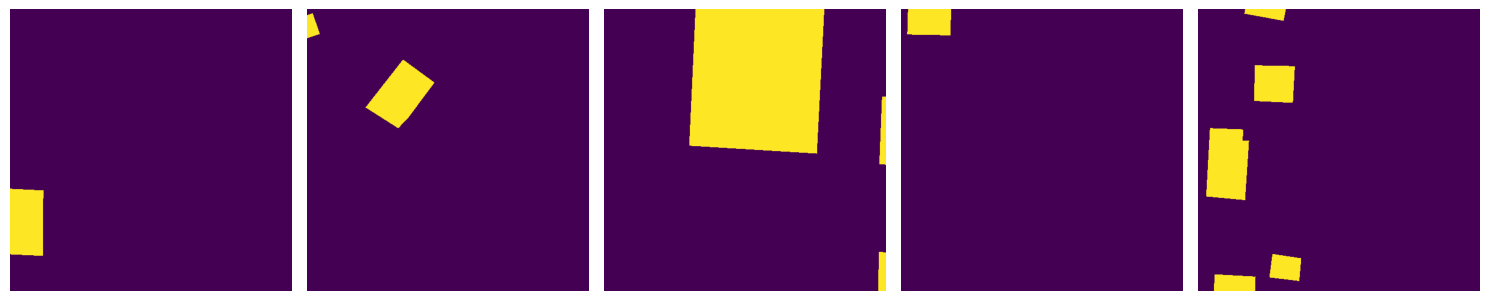

In [18]:
import random

## plot to see the results
plot_images(random.sample(list_bitmap,5))

### Pairwise plot 

In [ ]:
from src.utils.plots import plot_pairwise

## plot the pairwise 
# Create lookup dictionary
bitmap_dict = {Path(f).stem: f for f in list_bitmap}

# Find matches
matching_pairs = [(tile, bitmap_dict[Path(tile).stem]) 
                  for tile in list_files 
                  if Path(tile).stem in bitmap_dict]

Plotting 8 pairs in 4 rows x 2 pairs per row


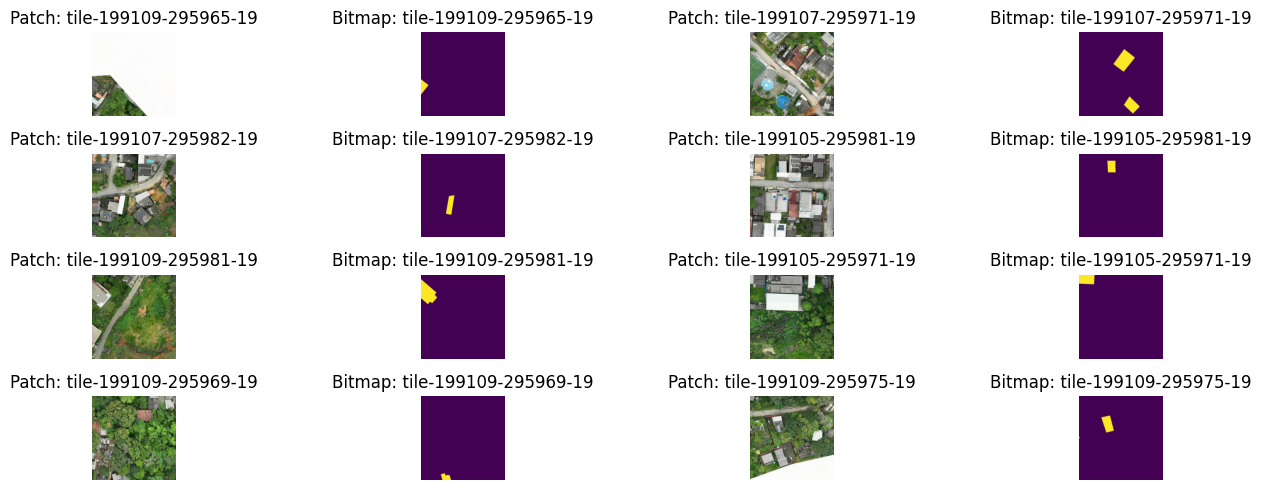

In [16]:
plot_pairwise(random.sample(matching_pairs, 8))

### Singular Image Check

In [ ]:
imgg= cv2.imread(list_files[random.randint(0,len(list_files))], ##RANDOM IMAGE
                 cv2.IMREAD_COLOR_RGB)

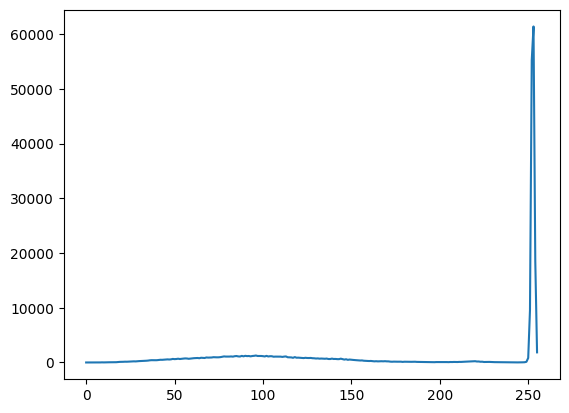

In [92]:
gray = rgb2gray(imgg)
counts, _= np.histogram(gray.flatten(),256)
plt.plot(counts)

## Creating Labels for Yolo models

In [59]:
imgg = cv2.imread(list_bitmap[5], cv2.IMREAD_GRAYSCALE)

In [62]:
imgg.max()

np.uint8(1)

### SINGULAR IMAGE 

In [ ]:
## read the bitmap as a grayscale image
imgg = cv2.imread(list_bitmap[50], cv2.IMREAD_GRAYSCALE)

## need to rescale the image to 0-255 instead of 0-1 
imgg_ = imgg_*255

## get vars
imgg_width, imgg_height = imgg.shape

## threshold
_, thresh = cv2.threshold(imgg_, 127, 255, 0)

## contour
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Process each contour
for cnt in contours:
    # Skip very small contours (noise)
    if cv2.contourArea(cnt) < 10:
        print(f"WARNING: Area of contour is lesser than threshold!")
        continue
    
    # Get bounding box
    x, y, w, h = cv2.boundingRect(cnt)
    
    # (normalized coordinates) 
    print(f"Bbox of normalized points: x_center, y_center, height, width") 
    x_center, y_center, w_, h_ = (x + w/2) / imgg_width, (y + h/2) / imgg_height, w / imgg_width, h / imgg_height
    print(f"0 {x_center:.8f} {y_center:.8f} {w_:.8f} {h_:.8f}\n")
    
    ## calculate the contour

0 0.956055 0.974609 0.08789062 0.05078125

0 0.876953 0.924805 0.07812500 0.15039062



In [ ]:

## Higher the epsilon, higher are the threshold of the Douglas-Peucked algorithm. Which means far and more rectangular than a smaller episolon
epsilon = cv2.arcLength(cnt, True)*0.002 ## 0.1 of the arclength (perimeter)

## In case of very complexed geometries. 
approx =  cv2.approxPolyDP(cnt, epsilon, True)

len(cnt), len(approx)


In [ ]:

def create_labels_yolov11_segmentation(list_bitmap, output_folder, skip_small_contour_areas=10,percent_epsilon=0.001, verbose=True):
    """ 
    Create a label.txt file, saving from a list of file names, in the specifiied folder, where the output_file is the same name as the input bitmap file.
    
    The labels follow the guideline of Ultralytics, where Each line holds an object with `class x_center y_center width height`
    Box coordinates must be in normalized xywh format (from 0 to 1). 
    This is designed for only ONE class number. It does not designed for a multi-class img_bitmap. 
    
    -----
    args:
        list_bitmap:
        A list of image paths. The path it is the absolute path of the image.
            A mask image range from (0,1).
        output_folder:
            Absolut path of the folder where to save it       
        skip_small_contour_areas:int 
            Sometimes the contour size is small and threholding this small contours help to only delineate the correct ones. The are is in pixel size.
        percent_epsilon:float
            This represent the percentual of the perimeter. A percent_episolon of 0.01 will return a epsilon of= perimter*percent_epsilon, which is 1% of the perimeter.
            Default=0.001 = 0.01%
    return:
        list_contour_less_thre:
            absolut path of partially/total unsuceed paths and the position of the contour
    """
    ## Create the dirs if does not exist
    os.makedirs(output_folder, exist_ok=True)
    print(f"The files are be written at: {output_folder}")
    
    list_contour_less_thre = []
    num_verbose=1
    ## Iter through the list
    for img_path in list_bitmap:
        ## Create the output_path
        name_file = ".".join([os.path.basename(img_path).split('.')[0],'txt'])
        output_path = os.path.join(output_folder, name_file)
        
        ## read the image
        imgg = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        ## need to rescale the image to 0-255 instead of 0-1 
        imgg_ = imgg*255

        ## get vars
        imgg_width, imgg_height = imgg.shape

        ## threshold
        _, thresh = cv2.threshold(imgg_, 127, 255, 0)

        ## contour
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Open output file
        with open(output_path, 'w') as f:
            
            # Process each contour
            for i,cnt in enumerate(contours):
                # Skip very small contours (noise)
                if cv2.contourArea(cnt) < 10:
                    print(f"WARNING: Area of contour is lesser than threshold!")
                    list_contour_less_thre.append((img_path, i))
                
                ## Higher the epsilon, higher are the threshold of the Douglas-Peucked algorithm. Which means far and more rectangular than a smaller episolon
                epsilon = cv2.arcLength(cnt, True)*percent_epsilon ## 0.1 of the arclength (perimeter)
                
                
                ## Smooth the mask in case of very complexed geometries. 
                approx =  cv2.approxPolyDP(cnt, epsilon, True)
                
                # Start with class_id
                line = "0"
                
                # Add normalized coordinates
                for point in approx:
                    x = point[0][0] / imgg_width
                    y = point[0][1] / imgg_height
                    line += f" {x:.8f} {y:.8f}"
                
                f.write(line + "\n")

        
        if verbose==True:
            print(f"Processed: {name_file} | {num_verbose/len(list_bitmap):.2%}")
            num_verbose+=1
            return list_contour_less_thre


### Classification

In [179]:
importlib.reload(labelling)

<module 'src.utils.labelling' from '/mnt/d/desktop/drone-mapping/code/dev/src/utils/labelling.py'>

In [180]:
from src.utils import labelling

In [129]:
from src.utils.labelling import create_labels_yolov11_classification

In [ ]:
output_folder = os.path.join(config['datasets']['root_folder'],config['datasets']['name_labels_folder'])
print(f"The files are being saved at: {output_folder}")


## Create the labels for the image
list_contours_lesser_thre_area = create_labels_yolov11_classification(list_bitmap, output_folder = output_folder)

The files are being saved at: /mnt/d/desktop/drone-mapping/data/new_tiling/labels
The files are be written at: /mnt/d/desktop/drone-mapping/data/new_tiling/labels
Processed: tile-199103-295977-19.txt | 1.39%
Processed: tile-199103-295978-19.txt | 2.78%
Processed: tile-199103-295981-19.txt | 4.17%
Processed: tile-199104-295966-19.txt | 5.56%
Processed: tile-199104-295967-19.txt | 6.94%
Processed: tile-199104-295969-19.txt | 8.33%
Processed: tile-199104-295970-19.txt | 9.72%
Processed: tile-199104-295971-19.txt | 11.11%
Processed: tile-199104-295977-19.txt | 12.50%
Processed: tile-199104-295978-19.txt | 13.89%
Processed: tile-199104-295979-19.txt | 15.28%
Processed: tile-199104-295982-19.txt | 16.67%
Processed: tile-199105-295965-19.txt | 18.06%
Processed: tile-199105-295966-19.txt | 19.44%
Processed: tile-199105-295967-19.txt | 20.83%
Processed: tile-199105-295968-19.txt | 22.22%
Processed: tile-199105-295969-19.txt | 23.61%
Processed: tile-199105-295970-19.txt | 25.00%
Processed: tile-

In [133]:
list_labels = glob.glob(os.path.join(
    config["datasets"]["root_folder"],
    config["datasets"]["name_labels_folder"],
    "*.txt"
))

In [140]:
with open(list_labels[random.randint(0,len(list_labels))], 'r') as f:
    print(f.name)
    print(f.read())

/mnt/d/desktop/drone-mapping/data/new_tiling/labels/tile-199107-295974-19.txt
0 0.97949219 0.41699219 0.04101562 0.08007812
0 0.66894531 0.21875000 0.22460938 0.25000000



### Segmentation Label


In [181]:
from src.utils.labelling import create_labels_yolov11_segmentation

In [182]:
output_folder = os.path.join(config['datasets']['root_folder'], config['datasets']['name_labels_segmentation'])
print(f"The files are being saved at : {output_folder}")

list_issues_ = create_labels_yolov11_segmentation(list_bitmap, output_folder, percent_epsilon=0.001)

The files are being saved at : /mnt/d/desktop/drone-mapping/data/new_tiling/labels_segmentation
The files are be written at: /mnt/d/desktop/drone-mapping/data/new_tiling/labels_segmentation
Processed: tile-199103-295977-19.txt | 1.39%
Processed: tile-199103-295978-19.txt | 2.78%


Processed: tile-199103-295981-19.txt | 4.17%
Processed: tile-199104-295966-19.txt | 5.56%
Processed: tile-199104-295967-19.txt | 6.94%
Processed: tile-199104-295969-19.txt | 8.33%
Processed: tile-199104-295970-19.txt | 9.72%
Processed: tile-199104-295971-19.txt | 11.11%
Processed: tile-199104-295977-19.txt | 12.50%
Processed: tile-199104-295978-19.txt | 13.89%
Processed: tile-199104-295979-19.txt | 15.28%
Processed: tile-199104-295982-19.txt | 16.67%
Processed: tile-199105-295965-19.txt | 18.06%
Processed: tile-199105-295966-19.txt | 19.44%
Processed: tile-199105-295967-19.txt | 20.83%
Processed: tile-199105-295968-19.txt | 22.22%
Processed: tile-199105-295969-19.txt | 23.61%
Processed: tile-199105-295970-19.txt | 25.00%
Processed: tile-199105-295971-19.txt | 26.39%
Processed: tile-199105-295977-19.txt | 27.78%
Processed: tile-199105-295978-19.txt | 29.17%
Processed: tile-199105-295979-19.txt | 30.56%
Processed: tile-199105-295980-19.txt | 31.94%
Processed: tile-199105-295981-19.txt | 

In [183]:
list_labels_seg = glob.glob(os.path.join(
    config["datasets"]["root_folder"],
    config["datasets"]["name_labels_segmentation"],
    "*.txt"
))

with open(list_labels_seg[random.randint(0,len(list_labels))], 'r') as f:
    print(f.name)
    print(f.read())

/mnt/d/desktop/drone-mapping/data/new_tiling/labels_segmentation/tile-199106-295980-19.txt
0 0.08398438 0.11132812 0.08398438 0.11523438 0.08593750 0.11718750 0.08593750 0.16796875 0.08789062 0.16992188 0.08789062 0.22070312 0.08984375 0.22265625 0.08984375 0.25195312 0.38671875 0.25195312 0.38671875 0.21289062 0.38867188 0.21093750 0.38867188 0.14648438 0.39062500 0.14453125 0.39062500 0.11523438 0.33593750 0.11523438 0.33398438 0.11328125 0.20703125 0.11328125 0.20507812 0.11132812
0 0.87304688 0.00000000 0.87304688 0.07421875 0.87500000 0.07617188 0.87500000 0.11132812 0.90039062 0.11132812 0.90234375 0.11328125 0.94921875 0.11328125 0.95117188 0.11523438 0.99609375 0.11523438 0.99804688 0.11718750 0.99804688 0.00000000



### Plot Label - Check

In [ ]:
from src.utils.util import compose_zip_folder
from src.utils.plots import plot_segmentation_label
from src.utils.labelling import read_segmentation_label

In [ ]:
matching_pairs =compose_zip_folder(list_folder1= list_labels_seg,  ## segmentation labels
                                   list_folder2=list_files) ## original RGB

In [199]:
matching_pairs[0]

('/mnt/d/desktop/drone-mapping/data/new_tiling/tiles/tile-199103-295977-19.tif',
 '/mnt/d/desktop/drone-mapping/data/new_tiling/labels_segmentation/tile-199103-295977-19.txt')

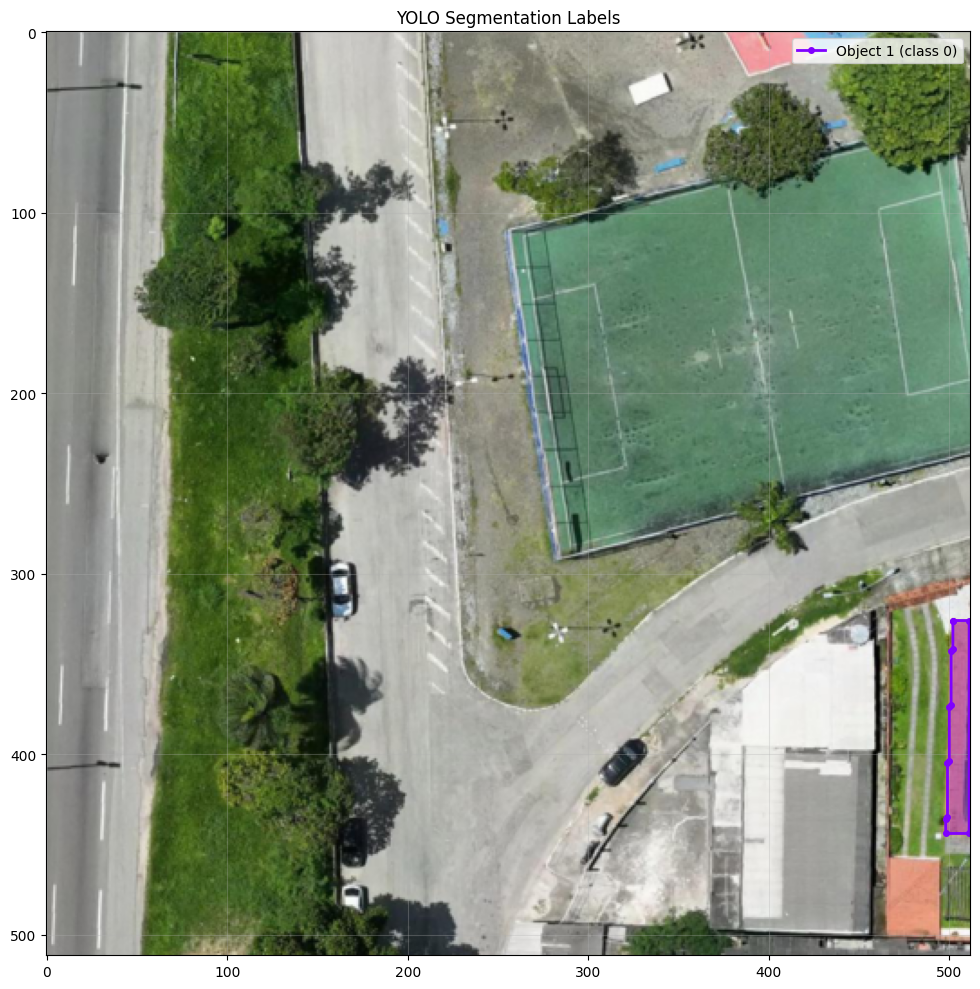

In [200]:
plot_yolo_segmentation(txt_path = matching_pairs[0][1], image_path=matching_pairs[0][0])

In [205]:
read_yolo_detection_label(list_labels[0])

[{'class_id': 0,
  'x_center': 0.98632812,
  'y_center': 0.75292969,
  'width': 0.02734375,
  'height': 0.23242188}]

In [207]:
zip_labels_classification = compose_zip_folder(list_labels, list_files)

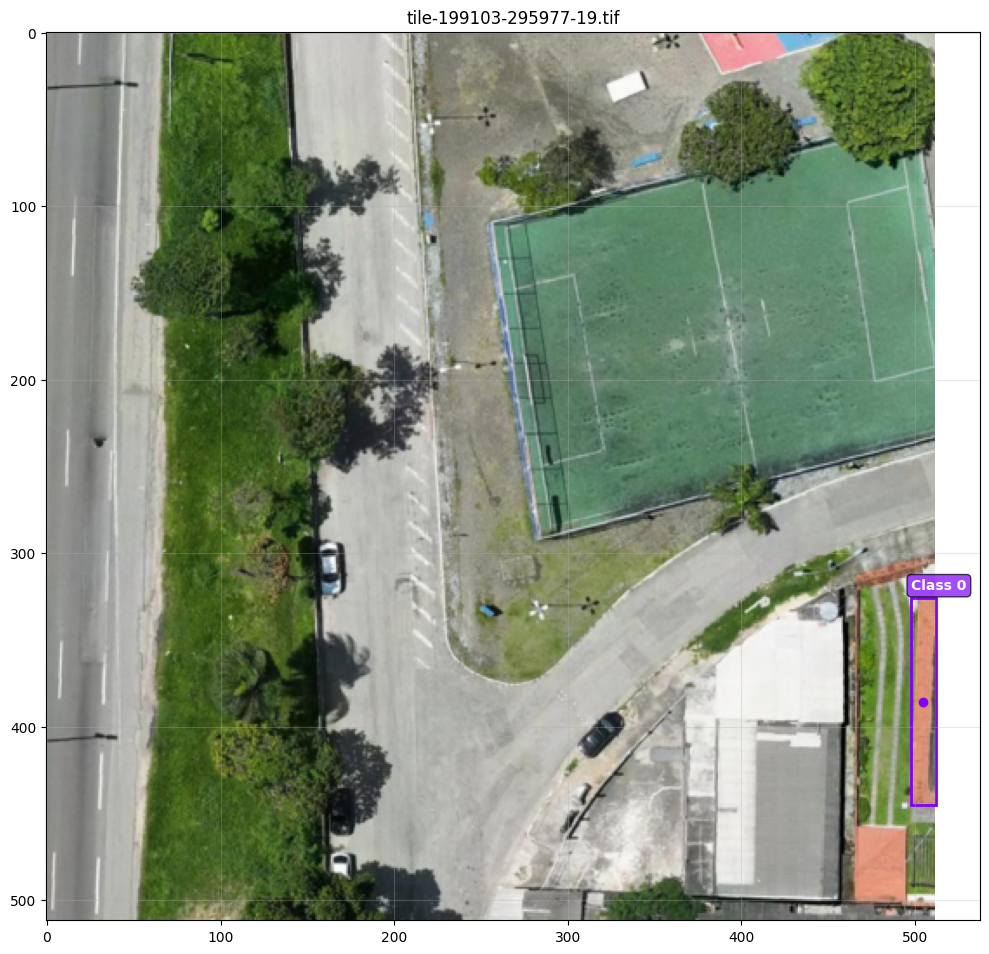

In [213]:
plot_yolo_detection(zip_labels_classification[0][1], zip_labels_classification[0][0])

In [203]:
def read_yolo_detection_label(txt_path):
    """
    Read a YOLO object detection label file (bounding boxes).
    
    Format: class_id x_center y_center width height
    All coordinates are normalized (0-1).
    
    Args:
        txt_path: Path to the .txt label file
        
    Returns:
        list of dictionaries, each containing:
            - 'class_id': int
            - 'x_center': float (normalized)
            - 'y_center': float (normalized)
            - 'width': float (normalized)
            - 'height': float (normalized)
    """
    boxes = []
    
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:  # Must have exactly 5 values
                continue
            
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            
            boxes.append({
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
    
    return boxes